<a href="https://colab.research.google.com/github/shajarian/Sentiment-LSTM-PySpark/blob/main/sentiment_LSTM_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -o "/content/drive/My Drive/Semester 3/Big Data/HW3/2/Airline.zip" -d "/content/dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/Semester 3/Big Data/HW3/2/Airline.zip
  inflating: /content/dataset/Tweets.csv  
  inflating: /content/dataset/database.sqlite  


Before tokenizing the text, make sure to clean up or fill null values. we can either filter out rows with null text or replace them with a default string, like an empty string.

Lets try elephas to train an LSTM model on the data preprocessed by pyspark. We should use framework like elephas as the PySpark's MLlib does not support LSTM.

In [ ]:
!pip install tensorflow
!pip install PySpark
#!pip install elephas

In [ ]:
# Start Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Airline Sentiment Analyisis").getOrCreate()

In [ ]:
# Load data
df = spark.read.csv('/content/dataset/Tweets.csv', header=True).select('text', 'airline_sentiment')

df.show(5)

+--------------------+-----------------+
|                text|airline_sentiment|
+--------------------+-----------------+
|@VirginAmerica Wh...|          neutral|
|@VirginAmerica pl...|         positive|
|@VirginAmerica I ...|          neutral|
|"@VirginAmerica i...|         negative|
|@VirginAmerica an...|         negative|
+--------------------+-----------------+
only showing top 5 rows



In [ ]:
# Drop rows with null values in 'text' column to ensure data quality
df = df.na.drop(subset=["text"])

df.show()

+--------------------+-----------------+
|                text|airline_sentiment|
+--------------------+-----------------+
|@VirginAmerica Wh...|          neutral|
|@VirginAmerica pl...|         positive|
|@VirginAmerica I ...|          neutral|
|"@VirginAmerica i...|         negative|
|@VirginAmerica an...|         negative|
|@VirginAmerica se...|         negative|
|@VirginAmerica ye...|         positive|
|@VirginAmerica Re...|          neutral|
|@virginamerica We...|         positive|
|@VirginAmerica it...|         positive|
|@VirginAmerica di...|          neutral|
|@VirginAmerica I ...|         positive|
|@VirginAmerica Th...|         positive|
|@VirginAmerica @v...|         positive|
|@VirginAmerica Th...|         positive|
|@VirginAmerica SF...|         negative|
|@VirginAmerica So...|         positive|
|@VirginAmerica  I...|         negative|
|I ❤️ flying @Virg...|         positive|
|@VirginAmerica yo...|         positive|
+--------------------+-----------------+
only showing top

In [ ]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover

tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = tokenizer.transform(df)
df = remover.transform(df)

As we know for feeding LSTM we need to use word embeddings to convert words to numeric form

In [ ]:
from pyspark.ml.feature import Word2Vec

word2vec = Word2Vec(vectorSize=100, minCount=0, inputCol="filtered_words", outputCol="features")

model = word2vec.fit(df)
df_w2v = model.transform(df)

In [ ]:
df_w2v.show()

+--------------------+-----------------+--------------------+--------------------+--------------------+
|                text|airline_sentiment|               words|      filtered_words|            features|
+--------------------+-----------------+--------------------+--------------------+--------------------+
|@VirginAmerica Wh...|          neutral|[@virginamerica, ...|[@virginamerica, ...|[-0.0028794696166...|
|@VirginAmerica pl...|         positive|[@virginamerica, ...|[@virginamerica, ...|[-0.0052797155804...|
|@VirginAmerica I ...|          neutral|[@virginamerica, ...|[@virginamerica, ...|[-0.0355764228152...|
|"@VirginAmerica i...|         negative|["@virginamerica,...|["@virginamerica,...|[-0.0068210307085...|
|@VirginAmerica an...|         negative|[@virginamerica, ...|[@virginamerica, ...|[-0.0149588322266...|
|@VirginAmerica se...|         negative|[@virginamerica, ...|[@virginamerica, ...|[-0.0479785897769...|
|@VirginAmerica ye...|         positive|[@virginamerica, ...|[@v

In [ ]:
df_w2v.show(5)

+--------------------+-----------------+--------------------+--------------------+--------------------+
|                text|airline_sentiment|               words|      filtered_words|            features|
+--------------------+-----------------+--------------------+--------------------+--------------------+
|@VirginAmerica Wh...|          neutral|[@virginamerica, ...|[@virginamerica, ...|[-0.0028794696166...|
|@VirginAmerica pl...|         positive|[@virginamerica, ...|[@virginamerica, ...|[-0.0052797155804...|
|@VirginAmerica I ...|          neutral|[@virginamerica, ...|[@virginamerica, ...|[-0.0355764228152...|
|"@VirginAmerica i...|         negative|["@virginamerica,...|["@virginamerica,...|[-0.0068210307085...|
|@VirginAmerica an...|         negative|[@virginamerica, ...|[@virginamerica, ...|[-0.0149588322266...|
+--------------------+-----------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="airline_sentiment", outputCol="label_index")
df_w2v = indexer.fit(df_w2v).transform(df_w2v)

In [ ]:
print(df_w2v.head())
df_w2v.show(5)

Row(text='@VirginAmerica What @dhepburn said.', airline_sentiment='neutral', words=['@virginamerica', 'what', '@dhepburn', 'said.'], filtered_words=['@virginamerica', '@dhepburn', 'said.'], features=DenseVector([-0.0029, 0.0153, 0.0223, -0.0116, 0.0247, -0.0126, -0.0027, -0.0156, -0.0117, 0.0034, 0.0112, -0.0066, 0.006, -0.0111, 0.007, 0.0285, -0.0, -0.0327, -0.0101, -0.0022, 0.0124, -0.0163, 0.018, 0.0187, -0.0057, -0.0049, -0.0062, 0.0114, -0.0172, -0.0071, 0.0063, -0.0032, -0.0106, -0.019, 0.0119, -0.0027, 0.0176, 0.006, 0.0128, 0.0087, 0.014, -0.0148, 0.0109, -0.0291, 0.0208, -0.009, 0.0012, 0.0126, -0.016, -0.0116, 0.0259, 0.0098, 0.002, -0.0144, 0.0081, 0.0067, -0.0073, 0.0106, -0.0092, -0.0055, -0.006, -0.0116, 0.0171, -0.0162, 0.0095, -0.0007, 0.0084, -0.0113, -0.0214, 0.0447, 0.0055, -0.0282, -0.0133, -0.0188, -0.0234, -0.0332, 0.0125, -0.0103, -0.0074, -0.0093, 0.0064, -0.0224, 0.022, -0.0127, 0.0234, -0.018, -0.0223, -0.0133, -0.0153, -0.0217, 0.0191, 0.0121, -0.0198, -0.006

In [ ]:
# Split data
train_data, test_data = df_w2v.randomSplit([0.8, 0.2])

In [ ]:
# Convert spark data frame to pandas
train_df = train_data.select("features", "label_index").toPandas()
test_df = test_data.select("features", "label_index").toPandas()

In [ ]:
print(train_df.head())

                                            features  label_index
0  [-0.04278501134831458, -0.04942865495104343, 0...          2.0
1  [-0.035400402412051335, -0.018164650246035308,...          0.0
2  [-0.011004748687040634, 0.01165059654830167, 0...          0.0
3  [-0.01910329320041152, -0.01516027688436831, -...          0.0
4  [-0.016305098581748702, -0.0038782895026088227...          0.0


In [ ]:
print(test_df.head())

                                            features  label_index
0  [-0.016092160575291406, -0.01841741678280024, ...          0.0
1  [-0.03483016036916524, -0.045208583294879645, ...          0.0
2  [-0.0027164461595627167, 0.0007620853915189703...          2.0
3  [-0.005870200824574567, -0.0010361282620579004...          0.0
4  [-0.033974397772302226, -0.02468698906401793, ...          0.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding

model = Sequential([
    LSTM(64, input_shape=(1, 100), return_sequences=True),
    Dropout(0.25),
    LSTM(32),
    Dropout(0.25),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Format Data for LSTM Training

In [ ]:
import numpy as np

X_train = np.array(train_df['features'].tolist())
# Reshape for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = tf.keras.utils.to_categorical(train_df['label_index'], num_classes=3)

# Prepare testing features and labels
X_test = np.array(test_df['features'].tolist())
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = tf.keras.utils.to_categorical(test_df['label_index'], num_classes=3)

In [ ]:
# Define the training parameters
batch_size = 32
epochs = 5

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Epoch 1/5
311/311 [==============================] - 8s 9ms/step - loss: 0.8813 - accuracy: 0.6360 - val_loss: 0.8068 - val_accuracy: 0.6575
Epoch 2/5
311/311 [==============================] - 2s 5ms/step - loss: 0.7853 - accuracy: 0.6629 - val_loss: 0.8036 - val_accuracy: 0.6564
Epoch 3/5
311/311 [==============================] - 2s 5ms/step - loss: 0.7643 - accuracy: 0.6718 - val_loss: 0.7847 - val_accuracy: 0.6940
Epoch 4/5
311/311 [==============================] - 2s 5ms/step - loss: 0.7538 - accuracy: 0.6809 - val_loss: 0.7860 - val_accuracy: 0.6741
Epoch 5/5
311/311 [==============================] - 2s 5ms/step - loss: 0.7487 - accuracy: 0.6856 - val_loss: 0.7752 - val_accuracy: 0.6707


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)

92/92 [==============================] - 1s 3ms/step


In [ ]:
# Evaluation using classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.93      0.80      1832
           1       0.54      0.19      0.28       616
           2       0.61      0.39      0.48       484

    accuracy                           0.69      2932
   macro avg       0.62      0.50      0.52      2932
weighted avg       0.66      0.69      0.64      2932



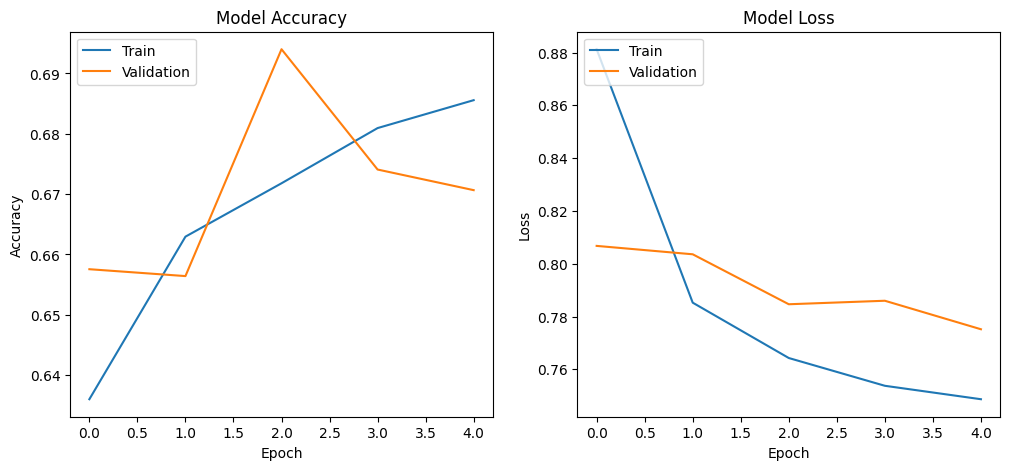

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
class_names = ['Negative', 'Neutral', 'Positive']

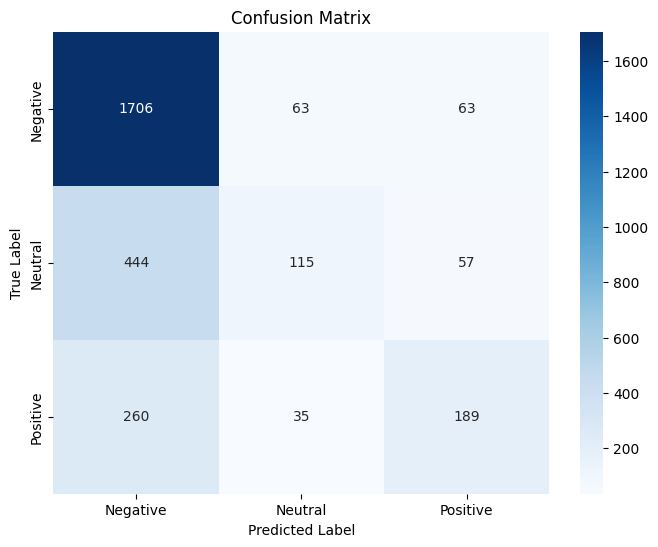

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

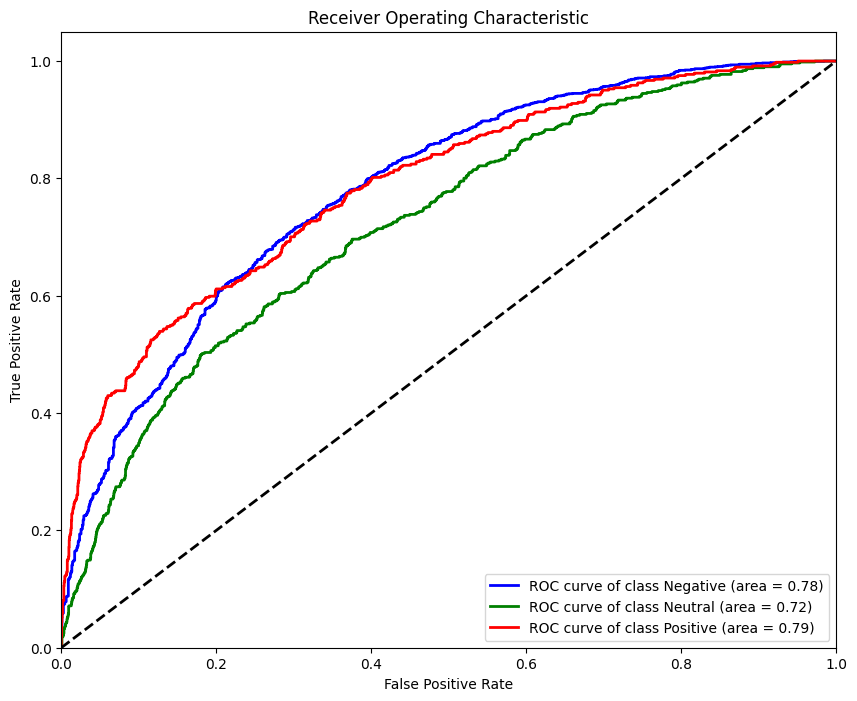

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(test_df['label_index'], classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()